In [1]:
# Enable autoreload for external modules
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import *

In [3]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
df = pd.read_csv(f"data/processed/spectrometry_photometry.csv")

In [5]:
input_features = ["velocityDisp",
                  "z",
                  "modelMag_z",
                  "d4000",
                  "zErr",
                  "petroRad_r",
                  "modelMag_r",
                  "nii_6584_flux",
                  "oiii_5007_flux"]

In [6]:
X = df[input_features]
y = df["logM_star"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 2
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 3
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 4
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

# Layer 5
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_64_2')(x)
x = layers.Dropout(0.2, name='Dropout_64_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_Model')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 9)]               0         
                                                                 
 Dense_64 (Dense)            (None, 64)                640       
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 Dense_256 (Dense)           (None, 256)               33024     
                                                                 
 Dropout_256 (Dropout)       (None, 256)          

In [10]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.4,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2925/2925 [==============================] - 35s 11ms/step - loss: 3.8354 - mae: 1.0577 - mse: 3.4488 - mape: 10.0178 - val_loss: 0.3484 - val_mae: 0.1394 - val_mse: 0.0466 - val_mape: 1.3658
Epoch 2/200
2925/2925 [==============================] - 34s 12ms/step - loss: 1.0997 - mae: 0.7180 - mse: 0.8511 - mape: 6.7884 - val_loss: 0.2331 - val_mae: 0.1100 - val_mse: 0.0336 - val_mape: 1.0804
Epoch 3/200
2925/2925 [==============================] - 35s 12ms/step - loss: 0.7266 - mae: 0.5997 - mse: 0.5723 - mape: 5.6750 - val_loss: 0.1470 - val_mae: 0.1021 - val_mse: 0.0325 - val_mape: 1.0030
Epoch 4/200
2925/2925 [==============================] - 34s 11ms/step - loss: 0.5299 - mae: 0.5289 - mse: 0.4448 - mape: 5.0073 - val_loss: 0.0900 - val_mae: 0.1025 - val_mse: 0.0298 - val_mape: 0.9995
Epoch 5/200
2925/2925 [==============================] - 34s 12ms/step - loss: 0.3885 - mae: 0.4667 - mse: 0.3471 - mape: 4.4203 - val_loss: 0.0681 - val_mae: 0.1475 - val_mse: 0.0404 - v

In [11]:
y_pred = model.predict(X_test_scaled)

2090/2090 [==============================] - 4s 2ms/step


In [12]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Dex accuracy metrics (since inputs are already in log space)
mae_dex = mae  # identical unless you're converting from linear scale
rmse_dex = rmse

print(f"📊 Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_dex:.4f} dex")
print(f"Root Mean Squared Error (RMSE): {rmse_dex:.4f} dex")
print(f"R² Score: {r2:.4f}")

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0839 dex
Root Mean Squared Error (RMSE): 0.1570 dex
R² Score: 0.9428


In [13]:
y_pred = y_pred.ravel()
type(y_pred), y_pred.shape
y_pred

array([10.656872,  9.855819, 11.351205, ...,  9.717272, 10.649706,
       10.346201], dtype=float32)

In [14]:
residuals = y_test - y_pred
residuals

180821    0.057148
179528    0.056036
95813     0.173835
84497     0.072039
191268   -0.066192
            ...   
193374    0.163674
50664     0.025074
35069    -0.181784
211331    0.123044
181018   -0.062541
Name: logM_star, Length: 66855, dtype: float64

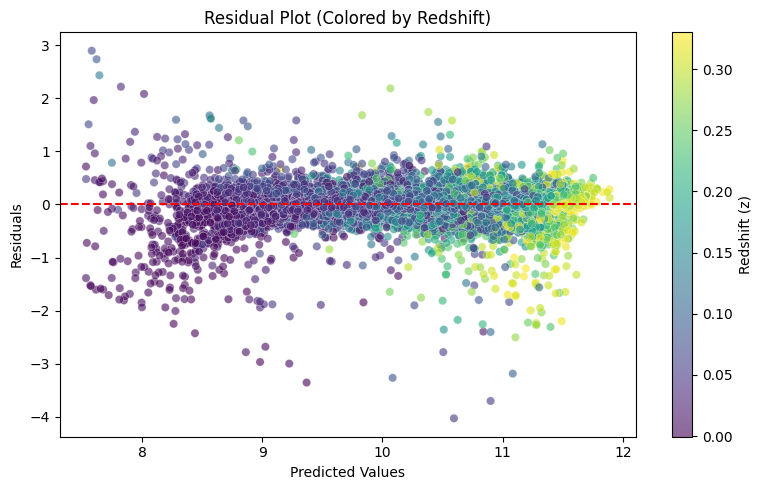

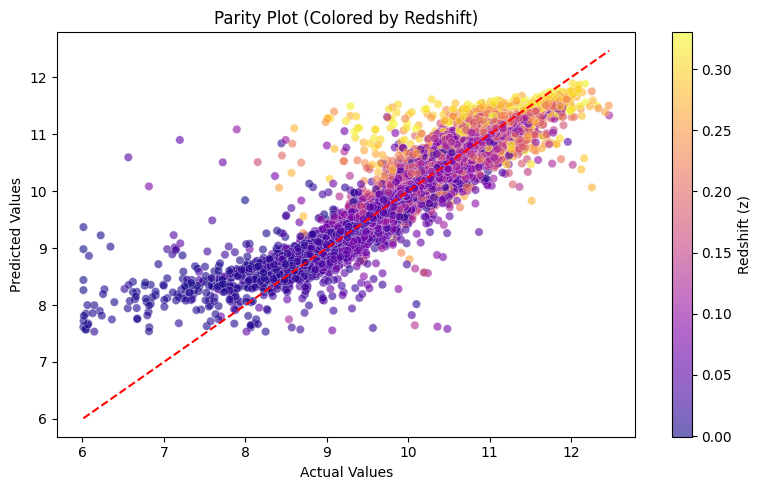

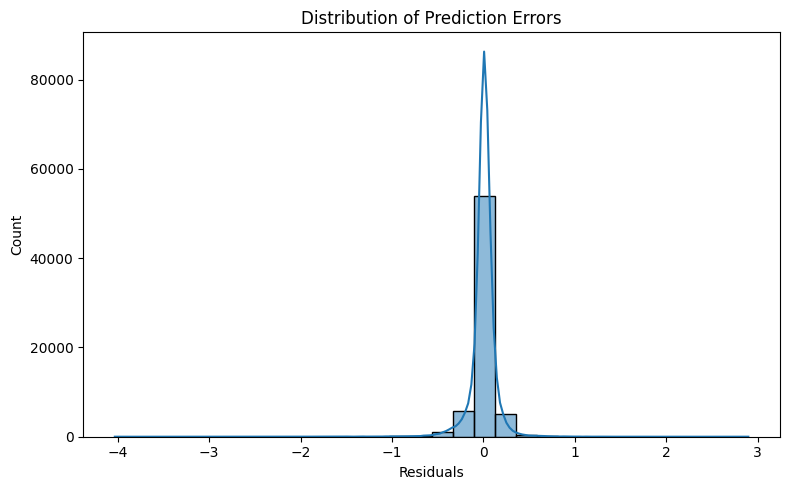

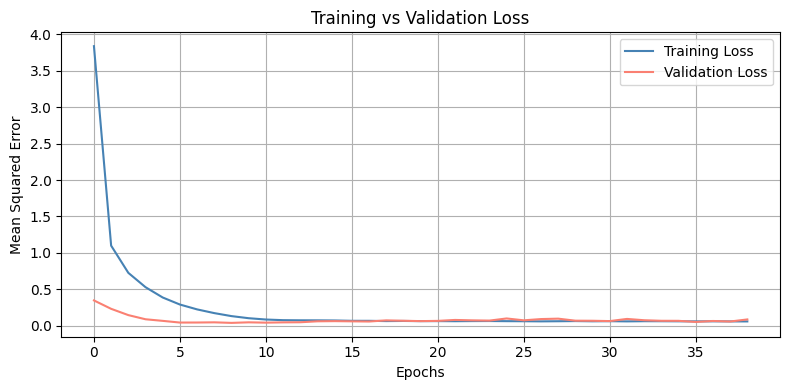

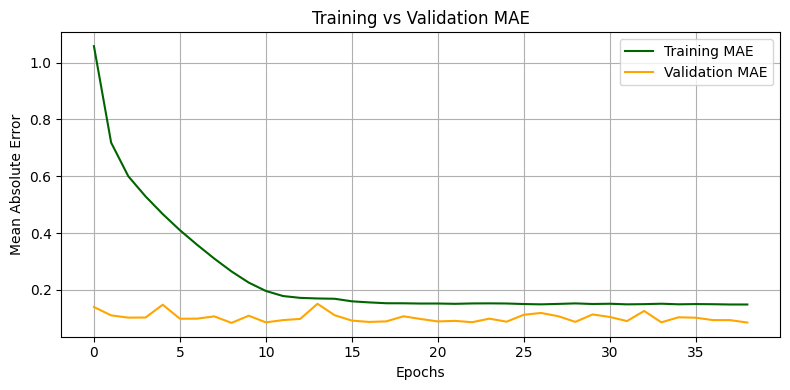

In [15]:
residuals = y_test - y_pred
z_values = X_test['z']
# Residual Plot
plt.figure(figsize=(8, 5))
if z_values is not None:
    scatter = plt.scatter(
        y_pred,
        residuals,
        c=z_values,
        cmap='viridis',
        alpha=0.6,
        edgecolors='w',
        linewidth=0.3
    )
    plt.colorbar(scatter, label='Redshift (z)')
else:
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Colored by Redshift)" if z_values is not None else "Residual Plot")
plt.tight_layout()
plt.show()

# Parity Plot
plt.figure(figsize=(8, 5))
if z_values is not None:
    scatter = plt.scatter(
        y_test,
        y_pred,
        c=z_values,
        cmap='plasma',
        alpha=0.6,
        edgecolors='w',
        linewidth=0.3
    )
    plt.colorbar(scatter, label='Redshift (z)')
else:
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot (Colored by Redshift)" if z_values is not None else "Parity Plot")
plt.tight_layout()
plt.show()

# Residual Distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Distribution of Prediction Errors")
plt.tight_layout()
plt.show()

if history is not None:
    # Determine if history is a dictionary or a Keras History object
    _history = None
    if isinstance(history, dict):
        _history = history
    elif hasattr(history, 'history'):
        _history = history.history
    else:
        raise ValueError("Invalid history object provided. It should be a dictionary or a Keras History object.")
    
    # Training vs Validation Loss
    plt.figure(figsize=(8, 4))
    plt.plot(_history['loss'], label='Training Loss', color='steelblue')
    plt.plot(_history['val_loss'], label='Validation Loss', color='salmon')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Training vs Validation MAE
    plt.figure(figsize=(8, 4))
    plt.plot(_history['mae'], label='Training MAE', color='darkgreen')
    plt.plot(_history['val_mae'], label='Validation MAE', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Absolute Error")
    plt.title("Training vs Validation MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()